In [1]:
# Imports 
import pdb
import os
os.environ['pyna_language'] = 'python'
import pandas as pd
import dymos as dm
import numpy as np
import datetime as dt
from typing import Union
import openmdao.api as om
from pyNA.src.settings import Settings
from pyNA.src.aircraft import Aircraft
from pyNA.src.trajectory_src.atmosphere import Atmosphere
from pyNA.src.engine import Engine
from scipy.interpolate import RegularGridInterpolator
from pyNA.src.trajectory_src.trajectory_ode import TrajectoryODE
from pyNA.src.trajectory_src.mux import Mux
from pyNA.src.trajectory_src.surrogate_noise import SurrogateNoise
from pyNA.pyna import pyna
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
pyna_settings = pyna.load_settings(case_name='stca')
pyna_settings.engine_file_name = "engine_deck_stca.csv"
pyna_settings.TS_cutback = None
pyna_settings.z_cutback = 25.
pyna_settings.save_results = False
pyna_settings.max_iter = 100

py = pyna(pyna_settings)
py.ac.load_aerodynamics(settings=py.settings)
py.engine.load_deck(settings=py.settings)

In [3]:
# Create aerodynamics cubic interpolants 
A  = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))
TF = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))
TS = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))
CL = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))
CD = np.zeros(np.size(py.ac.aero['alpha'])*np.size(py.ac.aero['theta_flaps'])*np.size(py.ac.aero['theta_slats']))

cntr = -1
for i, a in enumerate(py.ac.aero['alpha']):
    for j, tf in enumerate(py.ac.aero['theta_flaps']):
        for k, ts in enumerate(py.ac.aero['theta_slats']):
            cntr = cntr + 1
            A[cntr] = a
            TF[cntr] = tf
            TS[cntr] = ts
            CL[cntr] = py.ac.aero['c_l'][i,j,k]
            CD[cntr] = py.ac.aero['c_d'][i,j,k]

f_alpha_c_l = scipy.interpolate.Rbf(CL, TF, TS, A, function='cubic')
f_c_d = scipy.interpolate.Rbf(A, TF, TS, CD, function='cubic')

F_n_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['F_n'])

In [4]:
# Compute minimum thrust requirement
def compute_minimum_TS(settings, ac, F_n_interp, f_alpha_c_l, f_c_d, z, v, theta_flaps):
    
    # Initialize limiting cases
    case_lst = ['OEI', '4%CG']
    gamma_lst = np.array([0.0, np.arctan(0.04)*180/np.pi])
    nr_engine_lst = np.array([ac.n_eng - 1, ac.n_eng])

    sol = dict()
    sol['alpha'] = np.zeros(2)
    sol['c_l'] = np.zeros(2)
    sol['c_d'] = np.zeros(2) 
    sol['F_avail'] = np.zeros(2)
    sol['F_req'] = np.zeros(2)
    sol['TS'] = np.zeros(2)
    
    for i, case in enumerate(case_lst):
        # Compute atmospheric properties at ac.z_max
        prob_atm = om.Problem()
        prob_atm.model.add_subsystem("atm", Atmosphere(num_nodes=1, settings=settings))
        prob_atm.setup(force_alloc_complex=True)
        prob_atm.set_val('atm.z', z)
        prob_atm.run_model()
        rho_0 = prob_atm.get_val('atm.rho_0')
        c_0 = prob_atm.get_val('atm.c_0')
        
        # Lift requirement for steady flight
        L = 9.80665 * ac.mtow * np.cos(gamma_lst[i] * np.pi / 180.)
        sol['c_l'][i] = L / (0.5* rho_0 * v ** 2 * ac.af_S_w)

        # Compute required angle of attack to meet lift coefficient
        sol['alpha'][i] = f_alpha_c_l(sol['c_l'][i], theta_flaps, settings.theta_slats)
        
        # Compute corresponding drag coefficient
        sol['c_d'][i] = f_c_d(sol['alpha'][i], theta_flaps, settings.theta_slats)
        
        # Compute aircraft total thrust requirement
        T = (sol['c_d'][i] * 0.5 * rho_0 * v ** 2 * ac.af_S_w) + ac.mtow * 9.80065 * np.sin(gamma_lst[i] * np.pi / 180.)

        # Compute thrust requirement per engine
        sol['F_req'][i] = T / nr_engine_lst[i]
        
        # Compute thrust available
        sol['F_avail'][i] = (3/py.ac.n_eng)*F_n_interp((z, v / c_0, 1.))[0]

        # Compute minimum thrust setting
        sol['TS'][i] = sol['F_req'][i] / sol['F_avail'][i]
                
    # Return the maximum thrust requirement
    return np.min((np.max(sol['TS']), 0.999))

In [5]:
z_lst = np.linspace(0, 1500, 17)
v_lst = np.linspace(80, 130, 21)
theta_flaps_lst = np.linspace(0, 26, 14)

TS = np.zeros((17, 21, 14))

for i, z in enumerate(z_lst):
    print(i)
    for j, v in enumerate(v_lst):
        for k, th_flaps in enumerate(theta_flaps_lst):
            
            TS[i,j,k] = compute_minimum_TS(py.settings, py.ac, F_n_interp, f_alpha_c_l, f_c_d, z, v, th_flaps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


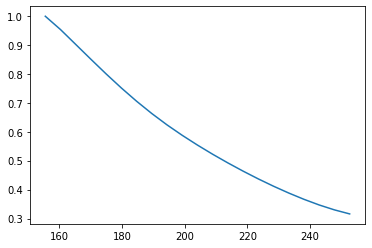

In [12]:
plt.plot(v_lst/0.514444, TS[0,:,5])


In [82]:
class settings:
    dT = 10.

z = np.linspace(0, 1000., 101)
T_0 = 288.15+settings.dT - 0.0065*z
c_0 = np.sqrt(1.4*287*T_0)

In [83]:
# Compute average speed of sound between source and observer
n_intermediate = 11
dz = z / n_intermediate
c_bar = c_0
for k in np.arange(1, n_intermediate):
    T_im = T_0 - k * dz * (-0.0065)
    c_im = np.sqrt(1.4 * 287. * T_im)
    c_bar = (k) / (k + 1) * c_bar + c_im / (k + 1)

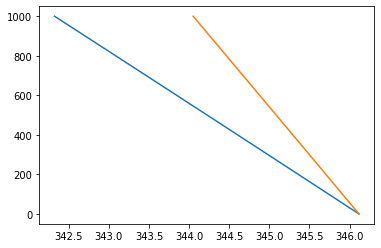

In [84]:
plt.plot(c_0, z)
plt.plot(c_bar, z)

In [23]:
dz

0.0